#Uczenie bez nauczyciela

Jest to okolejny paradygmat uczenia który poznamy, lekcja ta zaprezentuje różne algorymtmy w celu prezentacji możliwości i zastosowania tej metody. Tak jak zostało to już wsponiane w poprzedniej lekcji jedyne co mamy to dane i zadaniem modelu będzie analiza danych na własną rękę.

##Algorytmy

Nauka odbywa się poprzez [Klastrowanie (Clustering)](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68) - grupowanie danych o podobnych właściwościach w osobne grupy.

* Algorytm centroidów (K-means)
* Klastrowanie hierarchiczne (Hierarchical clustering)
* Grupowanie rozmyte (Fuzzy K-means)
* Mieszanka Gaussa (Mixture of Gaussians)

#Algorytm centroidów

##Teoria

W celu zrozumienia przykładu, należy w pierwszej kolejności zapoznać się na czym polega algorytm oraz jak działa. Zostaną tu przedstawione ogólne założenia, po więcej informacji odsyłam do [link](http://itcraftsman.pl/algorytm-k-srednich-uczenie-nienadzorowane/).

Podstawowe kroki algorytmu:

* Krok 1 - Rozmieszczenie zadanej ilości punktów
* Krok 2 - Rozmieszczenie k - ilości centroidów w losowych punktach
* Krok 3 - Przydielenie punktów do najbliższych centroidów na podstawie odległości
* Krok 4 - Wyliczenie środka masy pomiędzy wszystkimi punktami przydzielonymi do danego centroida i przeniesienie go w to miejsce
* Krok 5 - Ponowne przydzielenie punktów do najbliższych centroidów
* Krok 6 - Powtarzanie kroku 4 i 5 do momentu kiedy żaden z centroidów nie dokonuje przeniesienia

Warto zauważyć że mimo iż jest to typ uczenia bez nauczyciela który jest w teori niezależne od czynnika ludzkiego to ilość centroidów jest z góry założona. W tym celu powstało [rozszerzenie](https://ieeexplore.ieee.org/abstract/document/9072123) algorytmu które ma za zadanie samo ustalić optymalną liczbę.

##Przykład
Należy sobie zdawać sprawę że każde rozwiązanie ma swoje wady i zalety, i o ile biblioteka Tensorflow posiada ogromne możiwości to algorytm ten nie jest jedną z nich.

Od wersji biblioteki 2.0 i w górę, zmiany w strukturze biblioteki spowodowały że algorytm ten nie jest możliwy do realizacji. Z tego powodu wymagane jest użycie wstecznej kompatybilności do konwersji modelu uczenia.

Poniższy przykład został zrealizowany za pomocą tego [kodu](https://www.tensorflow.org/api_docs/python/tf/compat/v1/estimator/experimental/KMeans).

###Parametry
Pierwszym krokiem oczywiście będzie wgranie potrzebnych bibliotek oraz dobranie takich parametrów jak ilość centroidów czy liczba punktów które będą do nich przydzielane. 

Punkty zostały wygenerowane w zadanym przedziale w formie 2-wymiarowej.

In [ ]:
%tensorflow_version 2.x
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt

num_points = 300
points = np.random.uniform(0, 1000, [num_points, 2])
num_clusters = 10

###Budowa modelu

Tak jak zostało to już wspomniane, do zbudowania modelu potrzebne jest użycie konwersji do starszej wersji biblioteki. Do trenowania modelu będzie również potrzebna funkcja wejścia, która skonwertuje dane do postaci tensora.

In [ ]:
def input_fn():
  return tf.compat.v1.train.limit_epochs(
     tf.convert_to_tensor(points, dtype=tf.float32), num_epochs=1)

kmeans = tf.compat.v1.estimator.experimental.KMeans(
    num_clusters=num_clusters, use_mini_batch=False)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpggtexaf_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


###Trenowanie

W celu przetrenowania modelu, należy wyznaczyć ilość epok, w których model będzie się uczył. Poniższy fragment kodu został usprawniony, aby przerywać działanie algorytmu w momencie kiedy żaden centroid nie dokonał przemieszczenia.

In [ ]:
num_iterations = 20                   #ilość epok
previous_centers = None
for _ in range(num_iterations):       #głowna pętla
  kmeans.train(input_fn)              #trenowanie
  cluster_centers = kmeans.cluster_centers()                 #wydobycie danych z modelu o nowym położeniu centroidów
  if previous_centers is not None:                           #wyznaczamy wartość zmiany położenia centroida
    print ('delta:', cluster_centers - previous_centers)
    if not np.any(cluster_centers - previous_centers):       #jeżeli żaden centroid nie został przeniesiony, przewij pętle
      print('iteracja {} / {} koniec algorytmu'.format(_, num_iterations))
      break                              
  previous_centers = cluster_centers  #aktualizacja danych centroidów
  print ('score:', kmeans.score(input_fn))
print ('cluster centers:', cluster_centers)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpggtexaf_/model.ckpt-39
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 39...
INFO:tensorflow:Saving checkpoints for 39 into /tmp/tmpggtexaf_/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 39...
INFO:tensorflow:loss = 4765580.0, step = 39
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 41...
INFO:tensorflow:Saving checkpoints for 41 into /tmp/tmpggtexaf_/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 41...
INFO:tensorflow:Loss for final step: 4765580.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-04-05T10:58:47
INFO:tensorf

###Mapowanie

W celu wizualizacji efektu nauki, należy zmapować punkty do konkretnych centroidów. Dodatkowo do kodu została dopisana pętla która dokona podziału punktów na listy podlegające poszczególnym centroidom, co będzie użyteczne przy wizualizacji.

In [ ]:
cluster_indices = list(kmeans.predict_cluster_index(input_fn))

new_list = []
for j in range(num_clusters):
  row = []
  for i in range(len(cluster_indices)):
    if cluster_indices[i] == j:
      row.append(points[i])
  row = np.array(row)
  new_list.append(row)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpggtexaf_/model.ckpt-57
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


###Wizualizacja

W ten sposób prezentuje się działanie algorytmu

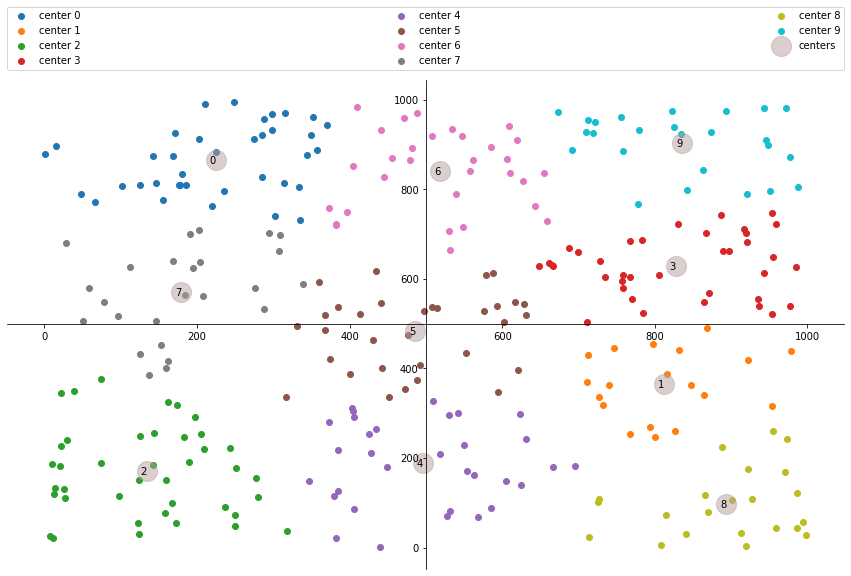

In [ ]:
fig = plt.figure()
fig.set_size_inches(15, 9)

# stworzenie głównej osi
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

#naniesienie każdego zbioru punktów na wykres
for i in enumerate(cluster_centers):
  index = i[0]
  plt.scatter(new_list[index][:,0], new_list[index][:,1], label='center {}'.format(index))
  plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)

#dodanie centroidów na wykres
plt.scatter(cluster_centers[:,0], cluster_centers[:,1],s=400, label='centers', color='#b89e9e', alpha=0.5)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)

#podpisanie centroidów na wykresie
for i in enumerate(cluster_centers):
    plt.annotate(i[0], (i[1][0]-8, i[1][1]-8))

plt.show()

###Pełny Kod

Poniżej znajduje się pełny kod z przykładu, zachęca się do modyfikacji parametrów w celu zbadania ich działania na algorytm.

In [ ]:
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt

num_points = 300
points = np.random.uniform(0, 1000, [num_points, 2])
num_clusters = 10

def input_fn():
  return tf.compat.v1.train.limit_epochs(
     tf.convert_to_tensor(points, dtype=tf.float32), num_epochs=1)

kmeans = tf.compat.v1.estimator.experimental.KMeans(
    num_clusters=num_clusters, use_mini_batch=False)

# train
num_iterations = 20
previous_centers = None
for _ in range(num_iterations):
  kmeans.train(input_fn)
  cluster_centers = kmeans.cluster_centers()
  if previous_centers is not None:
    print ('delta:', cluster_centers - previous_centers)
    if not np.any(cluster_centers - previous_centers): #optymalizacja
      print('iteracja {} / {} koniec algorytmu'.format(_, num_iterations))
      break                              
  previous_centers = cluster_centers
  print ('score:', kmeans.score(input_fn))
print ('cluster centers:', cluster_centers)

# map the input points to their clusters
cluster_indices = list(kmeans.predict_cluster_index(input_fn))

new_list = []
for j in range(num_clusters):
  row = []
  for i in range(len(cluster_indices)):
    if cluster_indices[i] == j:
      row.append(points[i])
  row = np.array(row)
  new_list.append(row)

fig = plt.figure()
fig.set_size_inches(15, 9)

# stworzenie głównej osi
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

#naniesienie każdego zbioru punktów na wykres
for i in enumerate(cluster_centers):
  index = i[0]
  plt.scatter(new_list[index][:,0], new_list[index][:,1], label='center {}'.format(index))
  plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)

#dodanie centroidów na wykres
plt.scatter(cluster_centers[:,0], cluster_centers[:,1],s=400, label='centers', color='#b89e9e', alpha=0.5)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)

#podpisanie centroidów na wykresie
for i in enumerate(cluster_centers):
    plt.annotate(i[0], (i[1][0]-8, i[1][1]-8))

plt.show()

#Klastrowanie kwiatu Irysa

Powyższy przykład zaprezentował działanie klastrowania na zbiorze losowych punktów, jest to tylko jedno z zastosowań. Może ono zostać użyte do przetwarzania danych używanych w uczeniu z nauczycielem i nie tylko.

Dla celów pokazowych zostanie użyty dataset zawierający klasyfikację kwiatów Irysa. Wiadomo, że dane zestawu można zaklasyfikować jako 3 kwiaty:
* Setosa
* Virginica
* Vericolor

Dzięki klastrowaniu możemy otrzymać tą informację, bez wcześniejszej znajomości zestawu danych.

##Import bibliotek i danych

W tym przykładzie zostanie wdrożone częściowe alternatywne rozwiązanie za pomocą biblioteki sklearn, która jest znacznie efektywniejsza przy realizacji algorytmu k-średnich.

In [ ]:
#importing the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import tensorflow as tf

dataset = datasets.load_iris()
x = dataset.data #dane zestawu
y = dataset.target_names #nazwy zbiorów

###Elbow

W uczeniu z nauczycielem istotnym elementem jest jak najmniejsza ingerecja ludzka, w tym celu stworzono algorytmy, których zadaniem jest znalezienie optymalnej liczby centroidów.

Jednym z tych algortmów jest [Elbow](https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/), którego realizacja jest względnie prosta. Zasada działania została podana w linku, w skrócie aby uzyskać optymalną liczbę centroidów należy spojrzeć na ostatnie "ostrzejsze skręcenie" prostych na wykresie.

Poniżej zostało to zrealizowane przy użyciu Sklearn oraz Tensorflow. Ta druga z bibliotek nie jest najlepszym wyborem do uczenia w paradygmacie uczenia bez nayczyciela, o czym można się przekonać kompilując i porównując oba rozwiązania. Więcej informacji o działaniu algorytmu k-średnich w Sklearn można przeczytać w [dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

###Elbow Sklearn

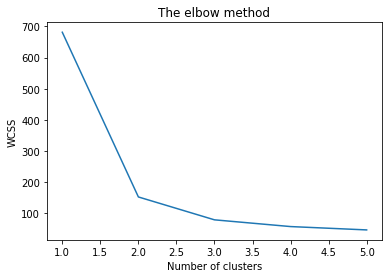

In [ ]:
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 6):
    kmeans = KMeans(n_clusters = i, init = 'random', max_iter = 10, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 6), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

###Elbow Tensorflow

Ta sama metoda z realizacją za pomocą biblioteki Tensorflow, różnica w czasie wykonania jest widoczna gołym okiem.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp0sxzcuyn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:ten

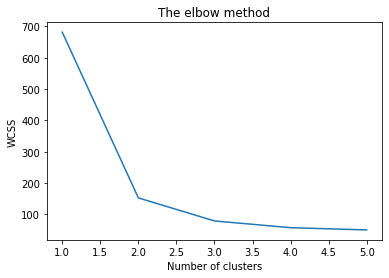

In [ ]:
def input_fn():
  return tf.compat.v1.train.limit_epochs(
     tf.convert_to_tensor(x, dtype=tf.float32), num_epochs=1)

wcss = []
for i in range(1, 6):
  kmeans = tf.compat.v1.estimator.experimental.KMeans(
  num_clusters=i, use_mini_batch=False)

  num_iterations = 10
  previous_centers = None
  for _ in range(num_iterations):
    kmeans.train(input_fn)
    cluster_centers = kmeans.cluster_centers()
    if previous_centers is not None:
      print ('delta:', cluster_centers - previous_centers)
      if not np.any(cluster_centers - previous_centers):
        print('iteracja {} / {} koniec algorytmu'.format(_, num_iterations))
        break                              
    previous_centers = cluster_centers
  wcss.append(kmeans.score(input_fn))

plt.plot(range(1, 6), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

##Klastrowanie

Obie iteracje wskazały 3 jako optymalną ilość centroidów, co jest zgodne z danymi zestawu. Dokonamy teraz klastrowania z użyciem kodu z poprzedniego przykładu.

In [ ]:
num_clusters=3

kmeans = tf.compat.v1.estimator.experimental.KMeans(
  num_clusters=num_clusters, use_mini_batch=False)

num_iterations = 10
previous_centers = None
for _ in range(num_iterations):
  kmeans.train(input_fn)
  cluster_centers = kmeans.cluster_centers()
  if previous_centers is not None:
    print ('delta:', cluster_centers - previous_centers)
    if not np.any(cluster_centers - previous_centers): #optymalizacja
      print('iteracja {} / {} koniec algorytmu'.format(_, num_iterations))
      break                              
  previous_centers = cluster_centers

cluster_indices = list(kmeans.predict_cluster_index(input_fn))

new_list = []
for j in range(num_clusters):
  row = []
  for i in range(len(cluster_indices)):
    if cluster_indices[i] == j:
      row.append(x[i])
  row = np.array(row)
  new_list.append(row)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp2c_dcpxw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:ten

##Wykres

Dane zestawu zostały wyświetlone w formie 2D jako punkty wykresu mimo posiadania 4 atrybutów, można na własną rękę zmienić atrubuty `atb_1` i `atb_2`, które odpowiadają pierwszej i drugiej własności kwiatu Irysa z zestawu danych.

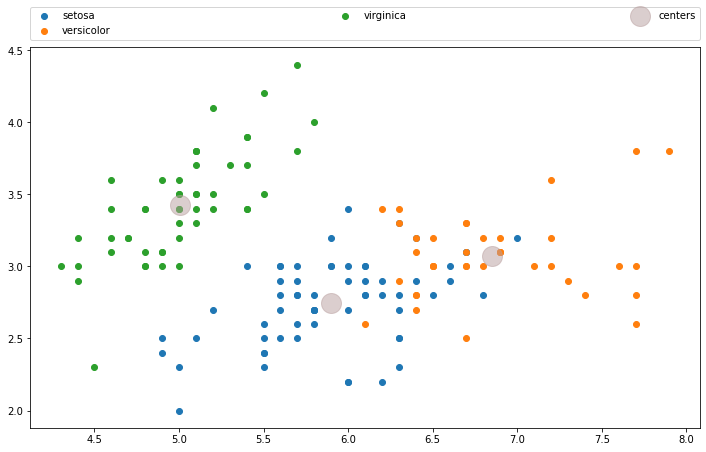

In [ ]:
fig = plt.figure()
fig.set_size_inches(12, 7)

atb_1 = 0
atb_2 = 1

#naniesienie każdego zbioru punktów na wykres
for i in enumerate(cluster_centers):
  index = i[0]
  plt.scatter(new_list[index][:,atb_1], new_list[index][:,atb_2],label=y[index])
  plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)

#dodanie centroidów na wykres
plt.scatter(cluster_centers[:,atb_1], cluster_centers[:,atb_2], s=400, label='centers', color='#b89e9e', alpha=0.5)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)

##Pełny kod

Jak widać uzyskujemy 3 wyraźne grupy. Liczba ta odpowiada ilości typów kwiatów.

Poniżej znajduje się pełny kod z przykładu, zachęcam do modyfikacji parametrów w celu zbadania ich działania na algorytm.

In [ ]:
#importing the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import tensorflow as tf

dataset = datasets.load_iris()
x = dataset.data #dane zestawu
y = dataset.target_names #nazwy zbiorów

from sklearn.cluster import KMeans
wcss = []

for i in range(1, 6):
    kmeans = KMeans(n_clusters = i, init = 'random', max_iter = 10, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 6), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

num_clusters=3

kmeans = tf.compat.v1.estimator.experimental.KMeans(
  num_clusters=num_clusters, use_mini_batch=False)

num_iterations = 10
previous_centers = None
for _ in range(num_iterations):
  kmeans.train(input_fn)
  cluster_centers = kmeans.cluster_centers()
  if previous_centers is not None:
    print ('delta:', cluster_centers - previous_centers)
    if not np.any(cluster_centers - previous_centers): #optymalizacja
      print('iteracja {} / {} koniec algorytmu'.format(_, num_iterations))
      break                              
  previous_centers = cluster_centers

cluster_indices = list(kmeans.predict_cluster_index(input_fn))

new_list = []
for j in range(num_clusters):
  row = []
  for i in range(len(cluster_indices)):
    if cluster_indices[i] == j:
      row.append(x[i])
  row = np.array(row)
  new_list.append(row)

fig = plt.figure()
fig.set_size_inches(12, 7)

atb_1 = 0
atb_2 = 1

#naniesienie każdego zbioru punktów na wykres
for i in enumerate(cluster_centers):
  index = i[0]
  plt.scatter(new_list[index][:,atb_1], new_list[index][:,atb_2],label=y[index])
  plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)

#dodanie centroidów na wykres
plt.scatter(cluster_centers[:,atb_1], cluster_centers[:,atb_2], s=400, label='centers', color='#b89e9e', alpha=0.5)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)

# Odnośniki

* https://datascience.eu/pl/matematyka-i-statystyka/tworzenie-klastrow/